# <div style="text-align:center"> DS7333 - Case Study 2 | Real-Time Location System</div>
### <div style="text-align:center">Andy Ho, An Nguyen, Jodi Pafford</div>
<div style="text-align:center">May 18, 2019</div>

## 1 Introduction
In this case study, we will be analyzing the RTLS data set using the k-nearest neighbors to determine locations and to determine potential issues with decisions made regarding the use, and non-use, of the data. We will conduct a more thorough data analysis into these two MAC addresses (00:0f:a3:39:e1:c0 and 00:0f:a3:39:dd:cd) determining locations by using data corresponding to both MAC addresses.  The following questions will be answered:
    - Which of these two MAC addresses should be used and which should not be used for RTLS?
    - Which MAC address yields the best prediction of location?
    - Does using data for both MAC addresses simultaneously yield more, or less, accurate prediction of location?
    
Furthermore, while k-nearest neighbors has proven to be a good approach to determining location, alternate approaches have been proposed.  One simple alternative approach is to use weights on the received signal strength, where the weight is inversely proportional to the “distance” from the test observation.  This allows for the “nearest” points to have a greater contribution to the k-nearest neighbor location calculation than the points that are “further” away.  We will implement  this alternative prediction method to answer:
    - For what range of values of weights are you able to obtain better prediction values than for the unweighted k-nearest neighbor approach?

## 2 Data Preparation
In this section, we'll use the offline.final.trace.txt data set from http://rdatasciencecases.org.  The code below will process, clean and build, and explore the RAW data.

### 2.1 Process RAW Data

In [16]:
options (digits = 2)

#Read in Offline Trace File
txt = readLines("offline.final.trace.txt")

#Locate lines that start with '#' 
sum(substr(txt, 1, 1) == "#")
length(txt)

#Fourth line of code ends with a semicolon.
strsplit(txt[4], ";")[[1]]

#Rearranging records to split at semicolong, equal, and comma character
tokens = strsplit(txt[4], "[;=,]")[[1]]

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

In [17]:
#First 10 lines
tokens[1:10]

#Extract values of variables
tokens[c(2, 4, 6:8, 10)]

#Remaining values in the split vector
tokens[ - ( 1:10 ) ]

#Create 4 columns for MAC, Signal, Channel, Device Type and populate from txt file
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE), 
            tmp)

#Confirm the matrix has 11 rows and 10 columns
dim(mat)

#Create function 'processLine' to repeat operation for each row in the file
processLine =
function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

#Apply function to several lines of input.  First 3 lines are comments to we start at line 4.
tmp = lapply(txt[4:20], processLine)

#This shows a list of 17 matrices and how many signals detected at each point
sapply(tmp, nrow)

#This stacks all the matrices into a dataframe called offline using the do.call function and rbind
offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

#Discard lines starting with '#' and pass rest to processLine function. results in 6 warnings
lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)

#Sets an option to handle errors.  Don't understand this line.  Nothing different occurs.
options(error = recover, warn = 1)
tmp = lapply(lines, processLine)

#Update processLine function to discard obseravations causing warnings.  line 82 had an warning...replaced with 'ncol ='
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

#running with updated processLines and store output to offline
options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

dim(offline)

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow

[1] 1181628      10

### 2.2 Clean and Build the RAW Data

In [18]:
#Adding headers to each column to 'offline' dataframe
names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

#Convert position, signal, and time variable sto numeric
numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

#Drop all records for adhoc measurements and remove the 'type' variable from dataframe
offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

#Convert the time to seconds from milliseconds
offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

#Checking the types of variables in the data frame
unlist(lapply(offline, class))

#Summary of each numerica value
summary(offline[, numVars])

#Convert the character variable to factors
summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

#modify dataframe by removing scanMac and PosZ
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX         posY           posZ  
 Min.   :2006-02-10 23:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 05:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 11:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 06:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 06:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 12:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

In [21]:
head(offline)

time,posX,posY,orientation,mac,signal,channel,rawTime
2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,1.1e+12
2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:90,-56,2427000000,1.1e+12
2006-02-10 23:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,1.1e+12
2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,1.1e+12
2006-02-10 23:31:58,0,0,0,00:14:bf:b1:97:81,-65,2422000000,1.1e+12
2006-02-10 23:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,1.1e+12


### 2.3 Explore the Data

[1] 203

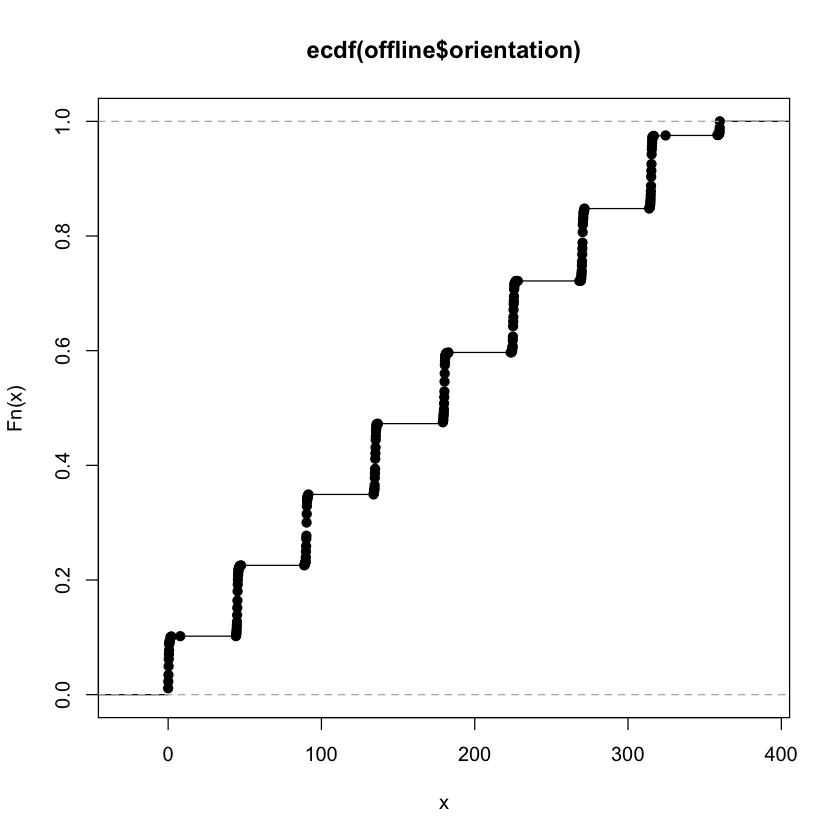

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

[1] 310

[1] 166

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


[1] TRUE

[1] 8

[1] 8

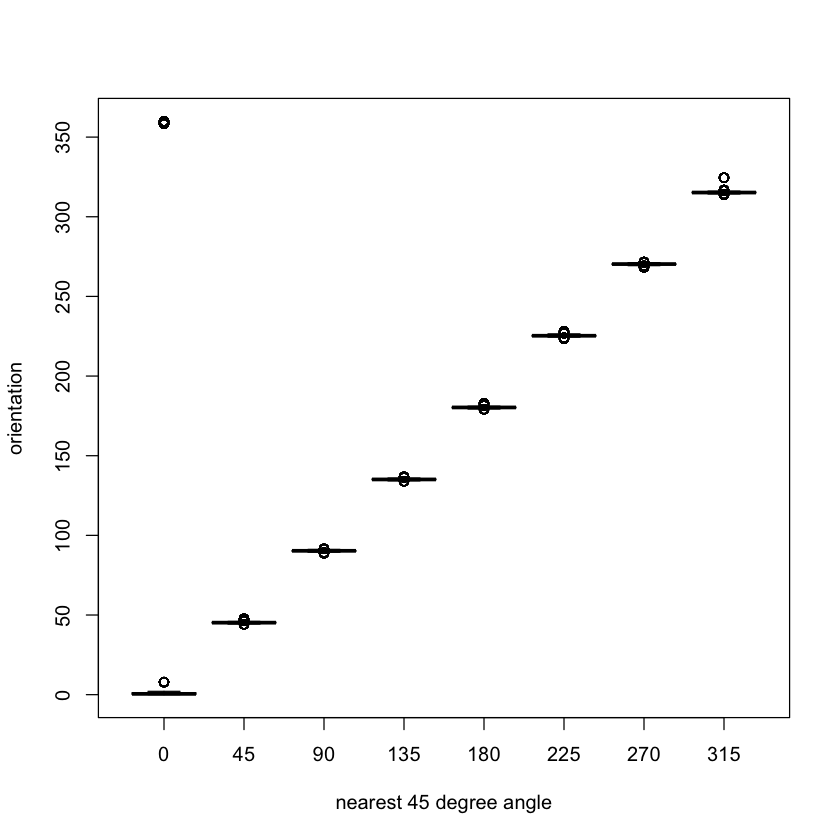

In [23]:
#verify the number of orientation
length(unique(offline$orientation)) 

#examine distribution of orientation
plot(ecdf(offline$orientation))  

#RoundOrientation Function
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

#create rounded angles
offline$angle = roundOrientation(offline$orientation)
with(offline, boxplot(orientation ~ angle,
                      xlab = "nearest 45 degree angle",
                      ylab="orientation"))

#number of unique addresses and channels.  There should only be 6 access points
c(length(unique(offline$mac)), length(unique(offline$channel))) 

table(offline$mac)

#keeping the records form top 7 devices
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

#reate a table of counts for the remaining MAC×channel combinations and confirm there is one non-zero entry in each row
macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

#remove channel from offline
offline = offline[ , "channel" != names(offline)]

#a list containing a data frame for each location 
locDF = with(offline,
             by(offline, list(posX, posY), function(x) x))
length(locDF)

#number of empty elements
sum(sapply(locDF, is.null))

#drop unneeded elements
locDF = locDF[ !sapply(locDF, is.null) ]
length(locDF)

#number of observation at each location
locCounts = sapply(locDF, nrow)
locCounts = sapply(locDF,
                   function(df)
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)
dim(locCounts)
locCounts[ , 1:8]

#plot the 166 counts
locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = 0.8, srt = 45) #this line has error


readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }
offlineRedo = readData()


identical(offline, offlineRedo) 